# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,LOC-MDS,no-book-author,609392,NaN
1,LOC-MDS,no-author-rec,310413,NaN
2,LOC-MDS,male,2386306,NaN
3,LOC-MDS,ambiguous,68590,NaN
4,LOC-MDS,unknown,1129000,NaN


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

C:\Users\michaelekstrand\AppData\Local\Temp\ipykernel_25108\233082166.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  book_counts = link_stats.pivot('dataset', 'gender', 'n_books')


gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,239945.0,533089.0,21817.0,238282.0,135014.0,179826.0,911746.0,2259719.0
BX-E,39633.0,57617.0,5079.0,15720.0,5433.0,5615.0,20073.0,149170.0
BX-I,69797.0,100775.0,8752.0,32351.0,10946.0,11351.0,40631.0,274603.0
GR-E,214182.0,316760.0,16312.0,102096.0,48542.0,786746.0,NaN,1484638.0
GR-I,216265.0,320738.0,16483.0,103860.0,49413.0,799427.0,NaN,1506186.0
LOC-MDS,730814.0,2386306.0,68590.0,1129000.0,310413.0,609392.0,NaN,5234515.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

C:\Users\michaelekstrand\AppData\Local\Temp\ipykernel_25108\71450322.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')


gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,4848893.0,6904772.0,800584.0,2110800.0,900009.0,2662295.0,4211633.0
BX-E,141648.0,181828.0,40889.0,25213.0,6932.0,7616.0,23059.0
BX-I,399256.0,461777.0,102193.0,71286.0,18035.0,20423.0,56193.0
GR-E,36532265.0,33278454.0,12574230.0,3591485.0,950821.0,12291188.0,NaN
GR-I,82759641.0,69696895.0,20765745.0,10080126.0,2973270.0,33264386.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.106184,0.235909,0.009655,0.105448,0.059748,0.079579,0.403478
BX-E,0.265690,0.386251,0.034048,0.105383,0.036422,0.037642,0.134565
BX-I,0.254174,0.366984,0.031871,0.117810,0.039861,0.041336,0.147963
GR-E,0.144265,0.213358,0.010987,0.068768,0.032696,0.529924,NaN
GR-I,0.143585,0.212947,0.010944,0.068956,0.032807,0.530762,NaN
LOC-MDS,0.139614,0.455879,0.013103,0.215684,0.059301,0.116418,NaN


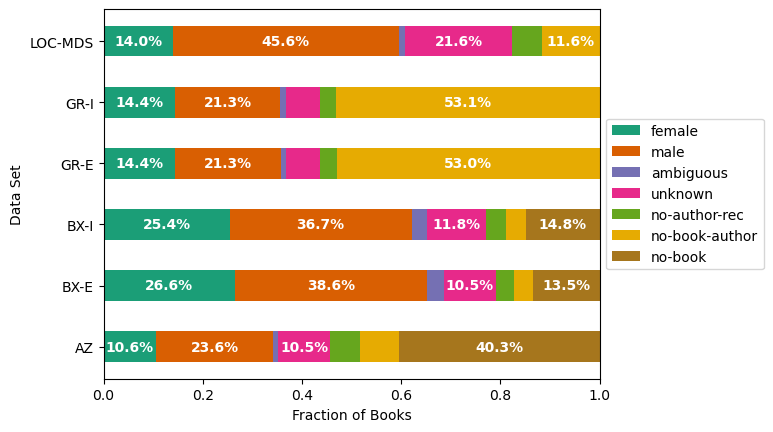

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.106184,0.235909,0.009655,0.105448,0.542805
BX-E,0.265690,0.386251,0.034048,0.105383,0.208628
BX-I,0.254174,0.366984,0.031871,0.117810,0.229160
GR-E,0.144265,0.213358,0.010987,0.068768,0.562621
GR-I,0.143585,0.212947,0.010944,0.068956,0.563569
LOC-MDS,0.139614,0.455879,0.013103,0.215684,0.175719


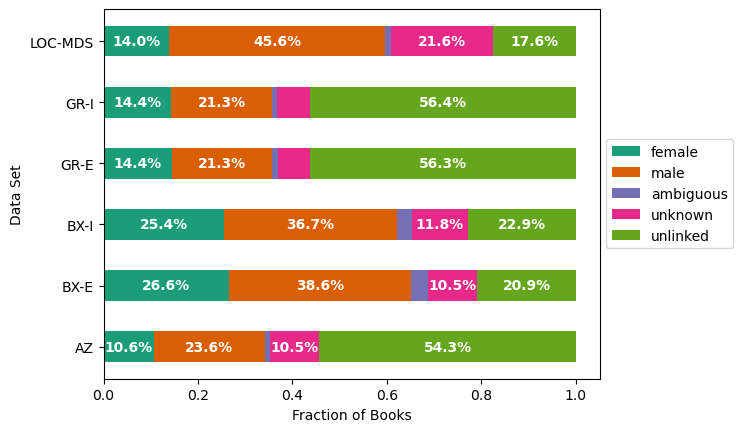

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

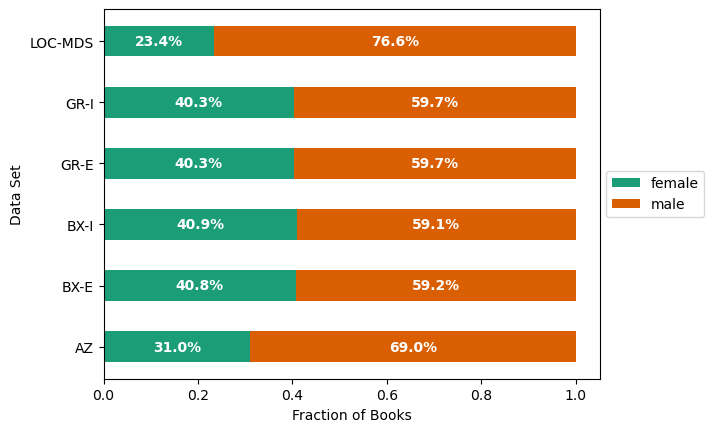

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.216092,0.307713,0.035678,0.094068,0.040109,0.118646,0.187693
BX-E,0.331585,0.425642,0.095717,0.059021,0.016227,0.017828,0.053979
BX-I,0.353586,0.408955,0.090503,0.063132,0.015972,0.018087,0.049765
GR-E,0.368200,0.335406,0.126733,0.036198,0.009583,0.123880,NaN
GR-I,0.376968,0.317468,0.094587,0.045915,0.013543,0.151519,NaN


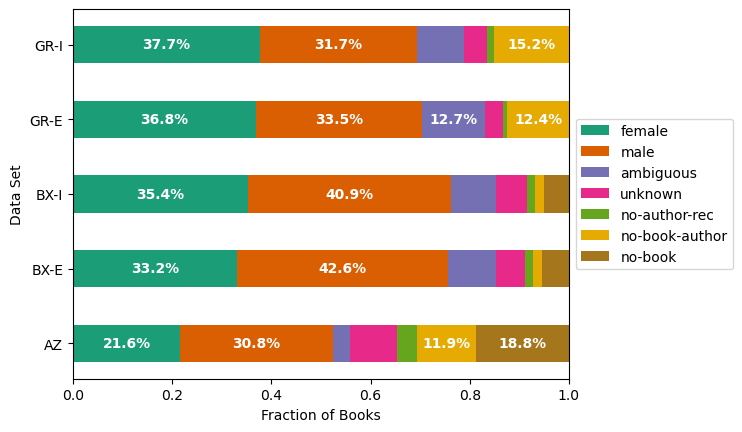

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.216092,0.307713,0.035678,0.094068,0.346448
BX-E,0.331585,0.425642,0.095717,0.059021,0.088034
BX-I,0.353586,0.408955,0.090503,0.063132,0.083824
GR-E,0.368200,0.335406,0.126733,0.036198,0.133463
GR-I,0.376968,0.317468,0.094587,0.045915,0.165062


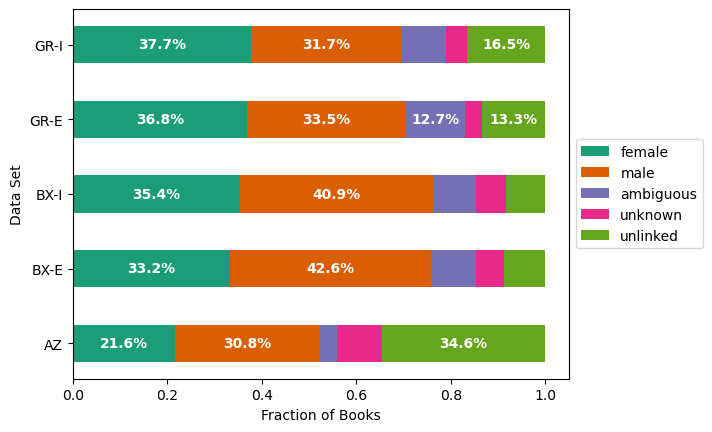

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

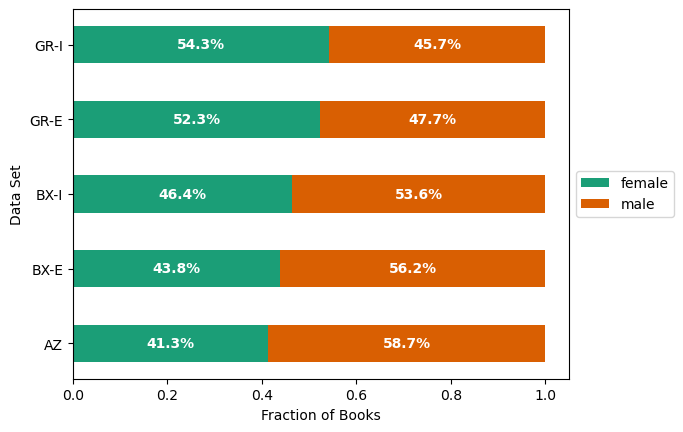

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ         0.351748
BX-E       0.685989
BX-I       0.653030
GR-E       0.368611
GR-I       0.367475
LOC-MDS    0.608597
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')